# Лабораторная работа №7
## ЧАСТОТНО-ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ ВРЕМЕННЫХ РЯДОВ
### Цыпаев Владимир Николаевич
### Вариант: 12
### Группа: РИМ-181228



In [2]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy import signal
import scipy
%matplotlib inline

ВР с ЛЧМ (линейной частотной модуляцией) в диапазоне от 50 до 150 Гц:

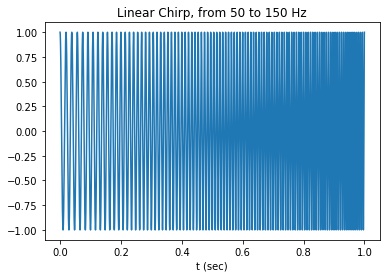

In [3]:
tx = np.linspace(0, 1, 8192) # временной отрезок от 0 до 1 сек
w = signal.chirp(tx, f0 = 50, f1 = 150, t1 = 1, method='linear')
# от 50 до 150 Гц за 1 секунду, ЛЧМ
plt.plot(tx, w)
plt.title("Linear Chirp, from 50 to 150 Hz")
plt.xlabel('t (sec)')
plt.show()

Построим спектрограмму заданного ряда, чтобы вычислить его
частотно-временные характеристики. Для этого сначала нам
потребуется рассчитать его частоту дискретизации:

In [4]:
fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
fs

8191.0

Строим спектрограмму по умолчанию:

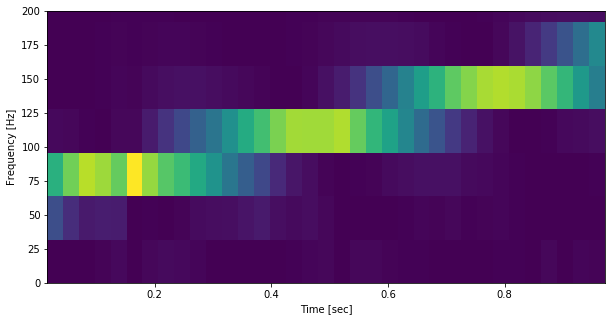

In [5]:
f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени
plt.figure(figsize = (10, 5))
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200) # строим до 200 Гц, иначе будет до fs/2
plt.xlabel('Time [sec]')
plt.show()

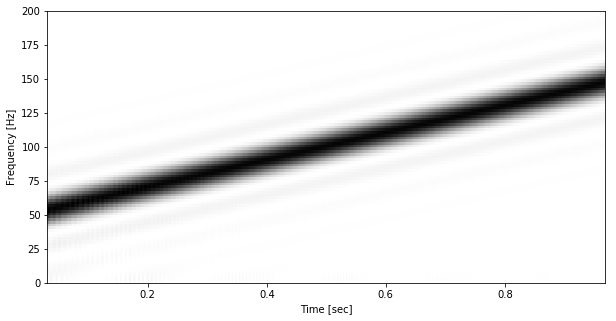

In [6]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
# длина каждого сегмента = 512, число пересекающихся точек между
#сегментами = 496, длина FFT = 4096
plt.figure(figsize = (10, 5))
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200)
plt.xlabel('Time [sec]')
plt.show()

__Преобразование Гильберта__ позволяет однозначно определить понятие аналитического сигнала, через который можно определить и функцию амплитудной модуляции (АМ, мгновенная амплитуда), и функцию фазы, и функцию __мгновенной частоты__ (instantaneous frequency), как производную от мгновенной фазы, то есть как раз искомую зависимость частоты от времени для ЧМ.

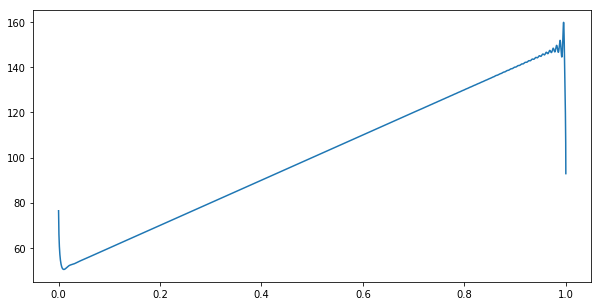

In [7]:
analytic_signal = signal.hilbert(w) # аналитический сигнал
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# мгновенная фаза в развернутом непрерывном виде

instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
# мгновенная частота как производная от фазы, приведенная в Гц
plt.figure(figsize = (10, 5))

# из-за численного расчета производной массив мгновенной частоты
# будет меньше массива времени на одну точку:
plt.plot(tx[1:], instantaneous_frequency)
plt.show()

Полученный график имеет четко выраженную линейную форму
частоты от 50 до 150 Гц, за исключением краевых эффектов, которые
все портят. Эти краевые искажения связаны с численным расчетом
производной от мгновенной частоты и на практике для избавления от
них полученный ряд сглаживают скользящим средним или
регрессионной кривой. 

Поэтому, на основе Ваших навыков из лабораторной работы №3
постройте линейный тренд для мгновенной частоты
instantaneous_frequency по методу линейной регрессии и по методу
скользящего среднего сглаживания. Оцените диапазон частоты
(значение частоты в начальной и конечной точках) в обоих случаях.

In [8]:
def inst_freq(tx, w):
    n = tx.shape[0]
    fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
    # аналитический сигнал
    analytic_signal = signal.hilbert(w) 
    
    # мгновенная фаза в развернутом непрерывном виде
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # мгновенная частота как производная от фазы, приведенная в Гц
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
    
    # из-за численного расчета производной массив мгновенной частоты
    # будет меньше массива времени на одну точку:
    tt = np.array(tx[1:])
    return tt, instantaneous_frequency

In [9]:
def f(t, b0, b1): # функция тренда
    return b0 + b1 * t

def f2(t, b0, b1, b2): 
    return b0 + b1 * t + b2 * t* t

def f3(t, b0, b1, b2, b3): 
    return b0 + b1 * t + b2 * t* t + b3 * t * t * t

def flog(t, b0, b1): 
    return  b0 + b1 *np.log(t)

def fexp(t, b0, b1): # после логарифмирования
    return  np.log(b0)+ b1 * t

def func(t, b):
    return b[0] + b[1]*t 

def func2(t, b): 
    return b[0] + b[1]*t + b[2]*t*t 

def func3(t, b): 
    return b[0] + b[1]*t + b[2]*t*t +b[3]*t*t*t

def funclog(t, b): 
    return b[0] + b[1]*np.log(t)

def funcexp(t, b): 
    return b[0] * np.exp(b[1]*t)

In [10]:
from scipy.optimize import curve_fit
def trend(t, Y, tr = 'smooth', cut = 0, window_len = 25):
    if cut > 0:
            Y = Y[cut: -cut]
            t = t[cut: -cut]
            
    if tr == 'linear':
        B_lin_curve_fit, pcov = curve_fit(f, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_lin_curve_fit)
        return t, np.array(func(t, B_lin_curve_fit))
    
    elif tr == 'quadratic':
        B_quad_curve_fit, pcov = curve_fit(f2, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_quad_curve_fit)
        return t, np.array(func2(t, B_quad_curve_fit))
    
    elif tr == 'hyperbolic':
        B_cubic_curve_fit, pcov = curve_fit(f3, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_cubic_curve_fit)
        return t, np.array(func3(t, B_cubic_curve_fit))
    
    elif tr == 'logarithmic':
        B_log_curve_fit, pcov = curve_fit(flog, t, Y)
        print("curve fit params ", B_log_curve_fit)
        return t, np.array(funclog(t, B_log_curve_fit))
    
    elif tr == 'exponential':
        B_exp_curve_fit, pcov = curve_fit(fexp, t, Y)
        print("curve fit params ", B_exp_curve_fit)
        return t, np.array(funcexp(t, B_exp_curve_fit))
    else:
        #smooth

        half_window=window_len//2
        Y=np.concatenate([[Y[0]]*half_window, Y, [Y[-1]]*half_window])
        smoothed=[]
    
        for i in range(half_window,len(Y)-half_window):
            smoothed.append(Y[i-half_window:i+1+half_window].sum()/window_len)
        return t, np.array(smoothed)
    

In [11]:
def plot_all(tx, w, tr, cut, window_len):
    n = tx.shape[0]
    fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
    
    f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
    
    tt, instantaneous_frequency = inst_freq(tx, w)
    tt, y = trend(tt, instantaneous_frequency, tr, cut, window_len)
    
    fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex = True)
    ax[0].plot(tx, w, label = 'signal w')
    ax[0].set_title("signal")

    ax[1].pcolormesh(t, f, Sxx, cmap='gray_r', label = 'Sxx')
    ax[1].set_title("spectrogram")
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_ylim(0, max(y)* 1.5)

    ax[2].plot(tx[1:], instantaneous_frequency, label = 'instantaneous_frequency', alpha = 0.5)
    ax[2].plot(tt, y, label = 'trend')
    ax[2].set_title("hilbert min = %1.2f max = %1.2f"%(min(y), max(y)))
    ax[2].set_ylabel('Frequency [Hz]')
    ax[2].set_xlabel('Time [sec]')

    ax[0].legend()
    #ax[1].legend()
    ax[2].legend()

    plt.tight_layout()
    plt.show()
    print("Frequency [Hz] [%1.2f, %1.2f]"%(min(y), max(y)))

Постройте зависимость частоты от времени для
следующих модельных временных рядов через спектрограмму и
преобразование Гильберта, не забывая сглаживать мгновенную
частоту регрессионной кривой:

## ЛЧМ

curve fit params  [50.29054296 99.38682755]


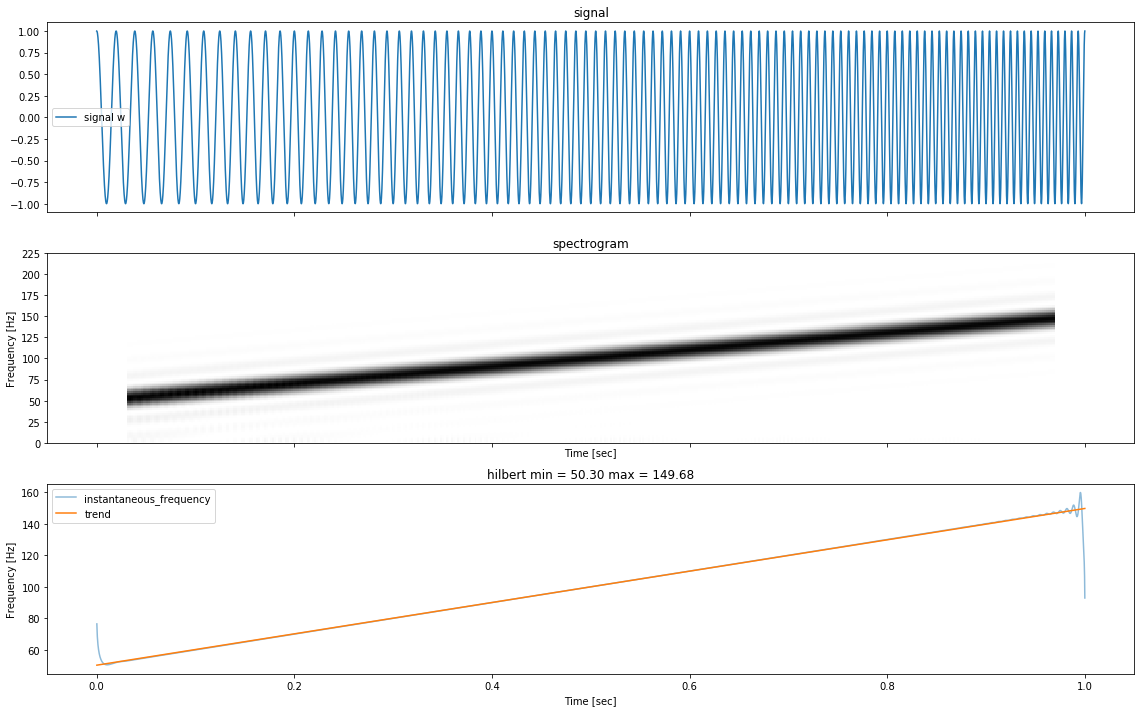

Frequency [Hz] [50.30, 149.68]
Frequency [Hz] [50     150   ]


In [12]:
tx = np.linspace(0, 1, 8192) # временной отрезок от 0 до 1 сек
w = signal.chirp(tx, f0=50, f1=150, t1=1, method='linear') 
plot_all(tx, w, 'linear', 0, 0)
print("Frequency [Hz] [50     150   ]")

## ЛЧМ в большем диапазоне

curve fit params  [ 200.26957572 2798.93318679]


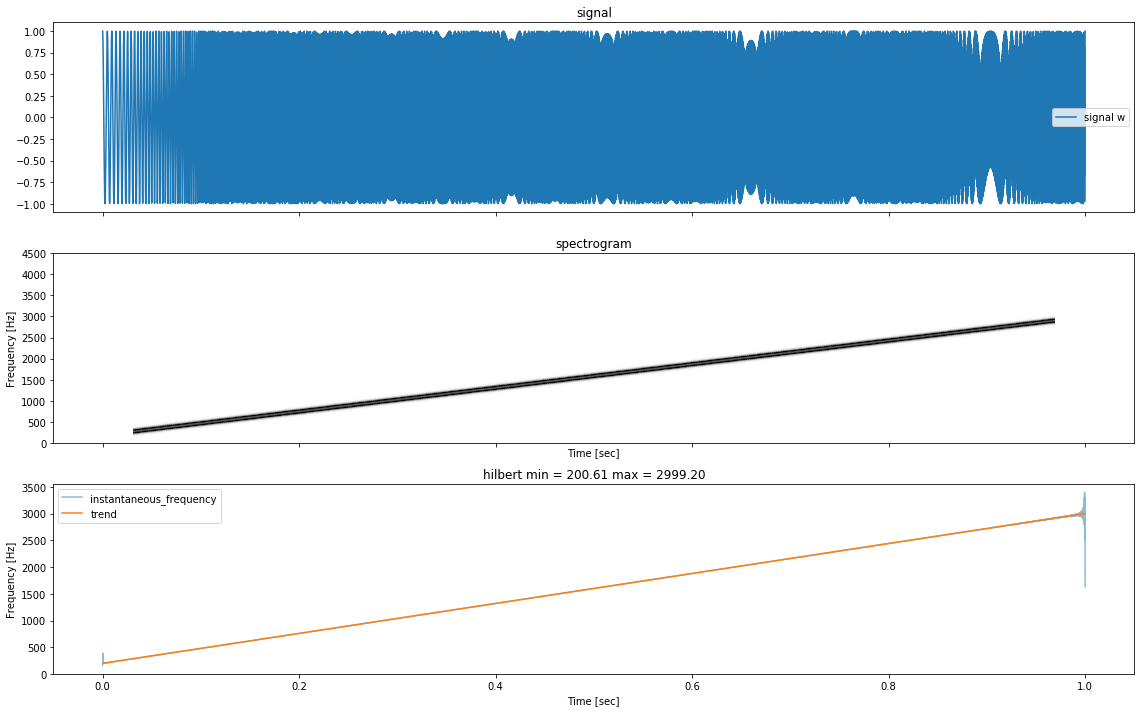

Frequency [Hz] [200.61, 2999.20]
Frequency [Hz] [200     3000   ]


In [13]:
tx = np.linspace(0, 1, 8192) # ЛЧМ в большем диапазоне
w = signal.chirp(tx, f0 = 200, f1 = 3000, t1 = 1, method='linear')
plot_all(tx, w, 'linear', 0, 0)
print("Frequency [Hz] [200     3000   ]")

## Ряд с квадратичной частотной модуляцией:

curve fit params  [ 1999.11862889     3.16018237 -1801.96277932]


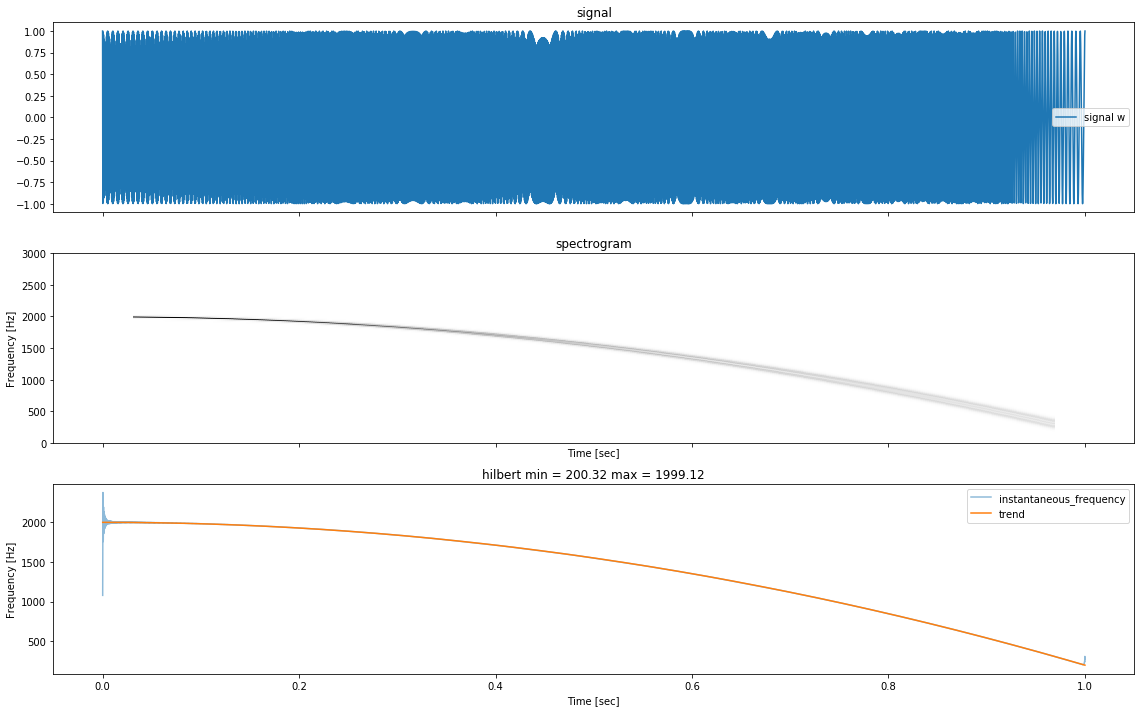

Frequency [Hz] [200.32, 1999.12]
Frequency [Hz] [200     2000   ]


In [14]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=2000, f1=200, t1=1, method='quadratic')
plot_all(tx, w, 'quadratic', 0, 0)
print("Frequency [Hz] [200     2000   ]")

## Ряд с инверсной квадратичной частотной модуляцией

curve fit params  [ 3200.86535699 -5605.80117929  2807.35353033]


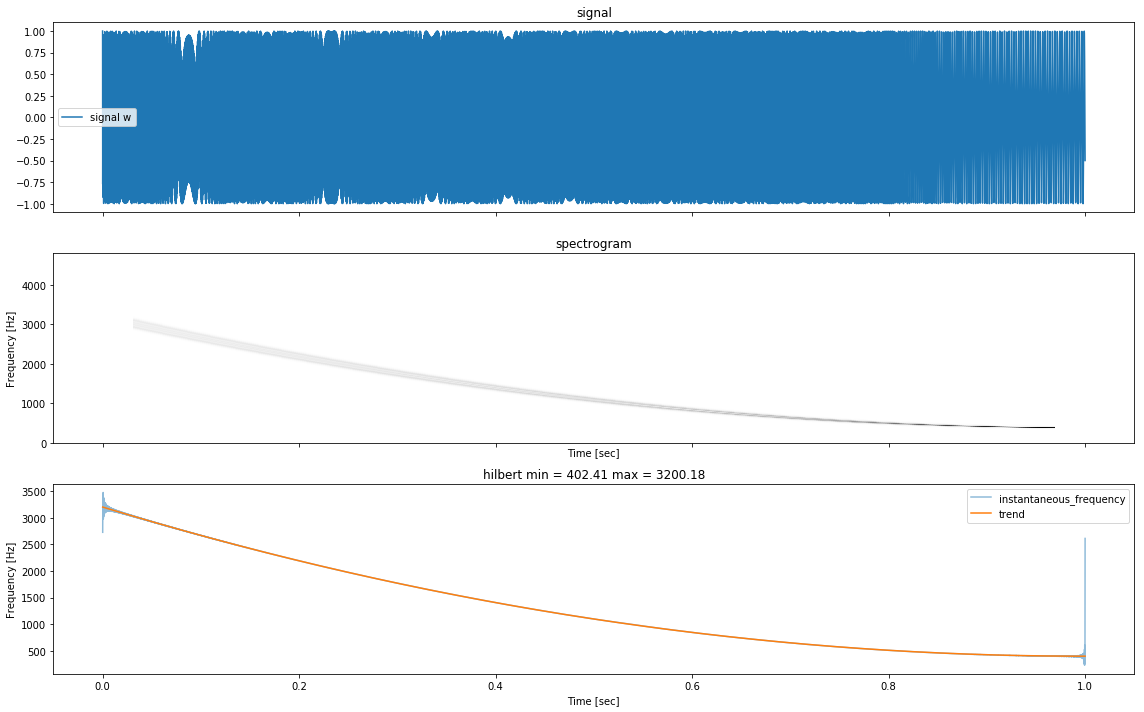

Frequency [Hz] [402.41, 3200.18]
Frequency [Hz] [400     3200   ]


In [15]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=3200, f1=400, t1=1, method='quadratic', vertex_zero=False)
plot_all(tx, w, 'quadratic', 0, 0)
print("Frequency [Hz] [400     3200   ]")

## Ряд с логарифмической частотной модуляцией: 

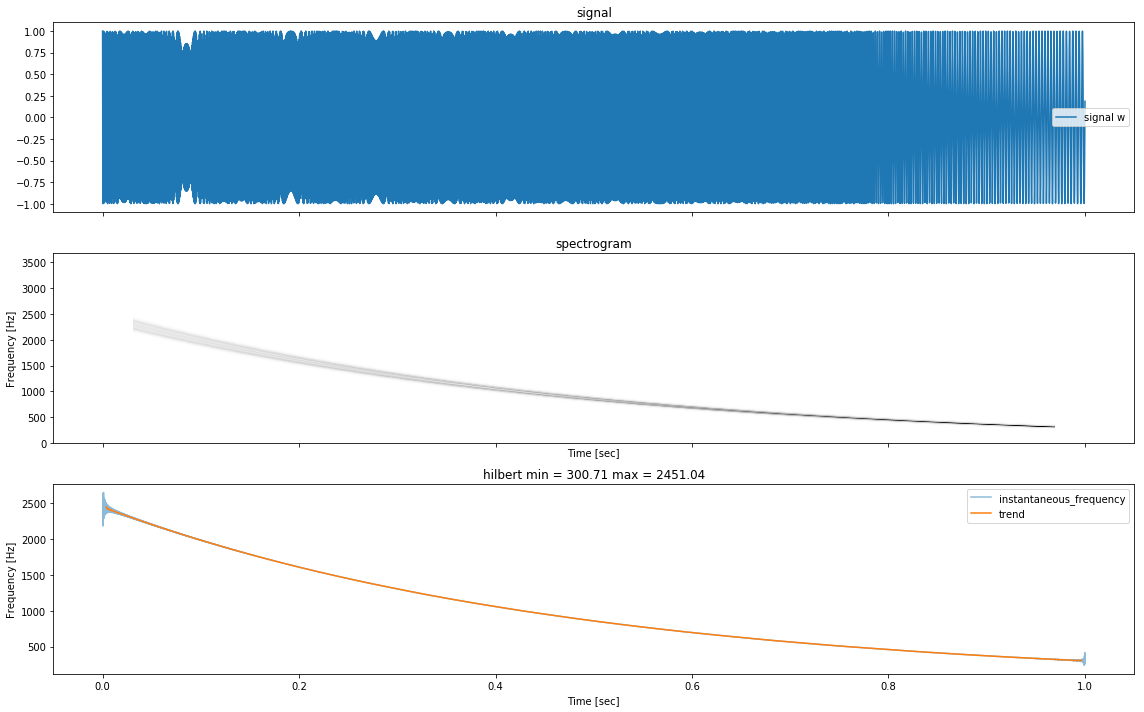

Frequency [Hz] [300.71, 2451.04]
Frequency [Hz] [300     2450   ]


In [16]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=2450, f1=300, t1=1, method='logarithmic')
# plot_all(tx, w, 'logarithmic', 30, 21)
plot_all(tx, w, 'smooth', 30, 21)
print("Frequency [Hz] [300     2450   ]")

## Ряд с гиперболической частотной модуляцией:

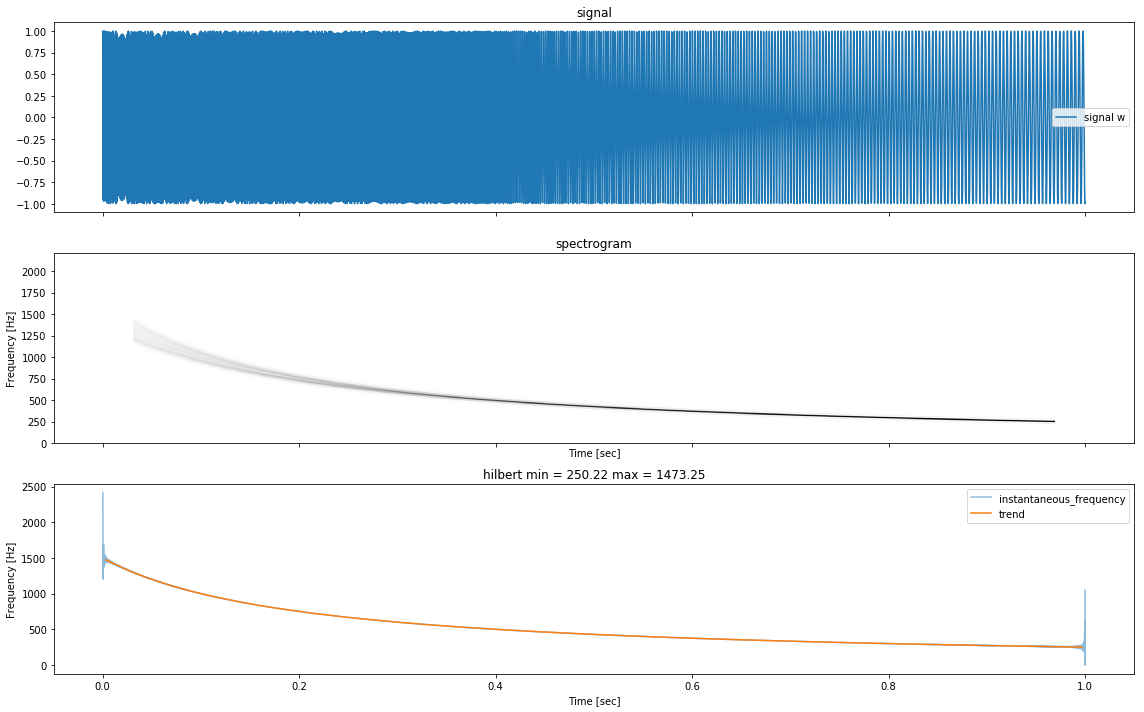

Frequency [Hz] [250.22, 1473.25]
Frequency [Hz] [250     1500   ]


In [17]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=1500, f1=250, t1=1, method='hyperbolic')
# plot_all(tx, w, 'hyperbolic', 25, 21)
plot_all(tx, w, 'smooth', 25, 21)
print("Frequency [Hz] [250     1500   ]")

## Ряд с полиномиальной частотной модуляцией:

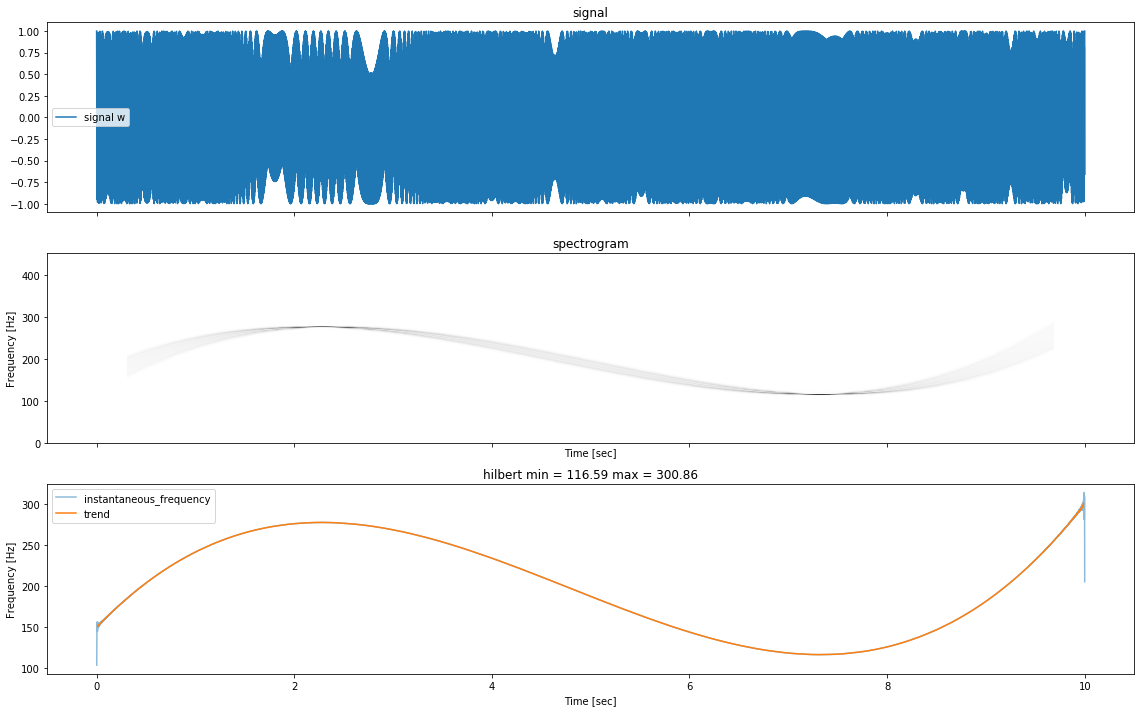

Frequency [Hz] [116.59, 300.86]
Frequency [Hz] [115     300   ]


In [18]:
tx = np.linspace(0, 10, 8192)
p = np.poly1d([2.5, -36.0, 125.0, 150.0])
w = signal.sweep_poly(tx, p)
plot_all(tx, w, 'smooth', 10, 5)
print("Frequency [Hz] [115     300   ]")

## Ряд с частотной модуляцией другим гармоническим сигналом:

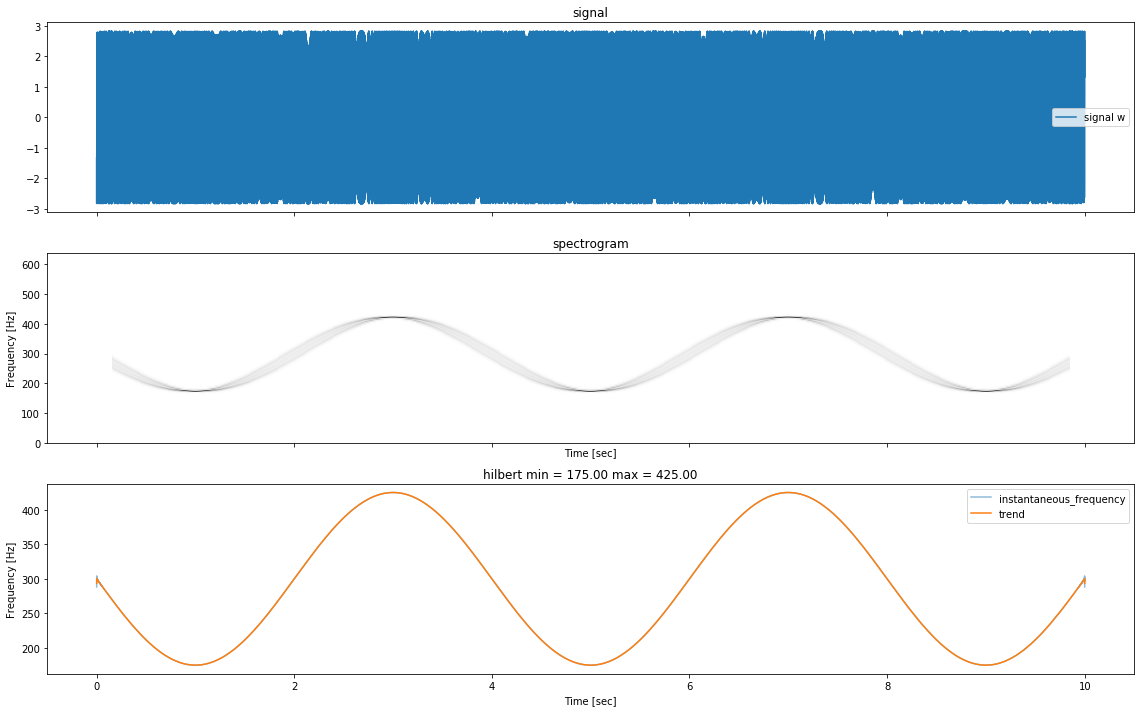

Frequency [Hz] [175.00, 425.00]
Frequency [Hz] [175     425   ]


In [19]:
tx = np.linspace(0, 10, 2*8192)
mod = 500*np.cos(2*np.pi*0.25*tx)
w = 2 * np.sqrt(2) * np.sin(2*np.pi*300*tx + mod)
plot_all(tx, w, 'smooth', 0, 3)
print("Frequency [Hz] [175     425   ]")

## Ряд с частотным изломом:

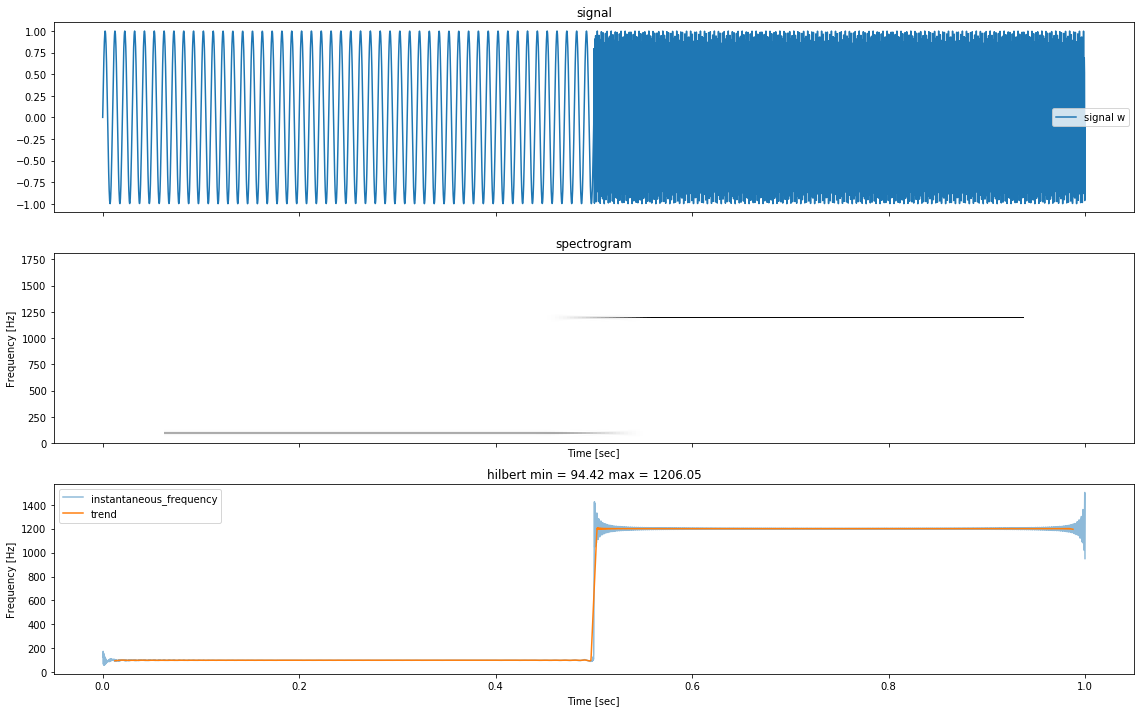

Frequency [Hz] [94.42, 1206.05]
Frequency [Hz] [100     1200   ]


In [20]:
tx = np.linspace(0, 1, 4096)
xf = np.zeros(4096)
for i in range(0, len(tx)//2):
    xf[i] = np.sin(2*np.pi*100*tx[i])
for i in range(len(tx)//2, len(tx)):
    xf[i] = np.sin(2*np.pi*1200*tx[i])
plot_all(tx, xf, 'smooth', 50, 25)
print("Frequency [Hz] [100     1200   ]")

## Временной ряд из 4 гармоник без шума:

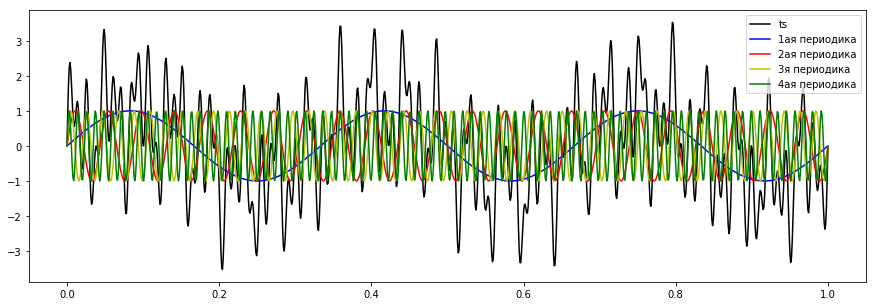

In [21]:
t = np.linspace(0, 1, 1024)
f1 = 3 #3
f2 = 23 #23
f3 = 48 #48
f4 = 87 #90
F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) \
    + np.sin(2*np.pi*f3*t) + np.sin(2*np.pi*f4*t)


plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k', label = 'ts')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b', label = '1ая периодика')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r', label = '2ая периодика')
plt.plot(t, np.sin(2*np.pi*f3*t), 'y', label = '3я периодика')
plt.plot(t, np.sin(2*np.pi*f4*t), 'g', label = '4ая периодика')
plt.legend()
plt.show()

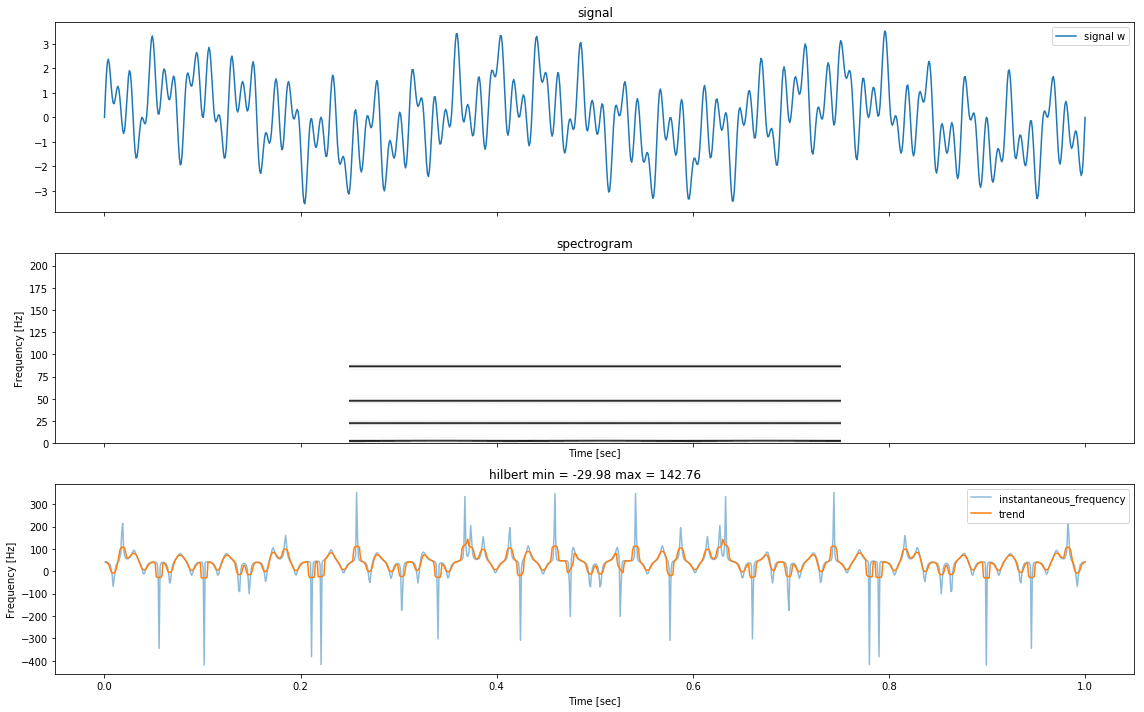

Frequency [Hz] [-29.98, 142.76]


In [22]:
plot_all(t, F, 'smooth', 0, 7)

В случае с последним временным рядом из нескольких периодик
для Преобразования Гильберта должен получиться неожиданный
результат – нечто совершенно не похожее ни коим образом на 4
разных, но постоянных периода. Связано это с тем, что сумма
гармоник трактуется через Преобразование Гильберта как единый
аналитический сигнал с некоторой сложной амплитудной
модуляцией (сумма синусов может быть записана как произведение
синуса на косинус).


# Эмпирическая Модовая Декомпозиция
Провести огибающие кривые в виде кубических сплайнов через максимумы (верхняя кривая) и минимумы (нижняя кривая) ряда, найти их среднее и вычесть из ряда (повторить 10 раз). Полученный остаток принять за компоненту, вычесть из ряда и начать все заново, пока не получатся все желаемые компоненты.

In [23]:
import scipy as sp
from scipy import signal

In [24]:
def emd(x, n_components = 3):
    
    r = x
    rr = r
    t = np.arange(len(r))
    components = np.zeros(n_components + 1, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = scipy.signal.argrelmax(r_tmp)[0]
            low_dots = scipy.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = scipy.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = scipy.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            mean_t = _emd_complim(mean_t, up_dots, low_dots)
            
            #samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            #samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            #mean_t[:samp_start] = mean_t[samp_start]
            #mean_t[samp_end:] = mean_t[samp_end]
            


            r_tmp = r_tmp - mean_t
                
        
        components[i] = r_tmp
        r = r - components[i] 
    
    components[n_components] = r
    return components

def _emd_complim(mean_t, up_dots, low_dots):
    samp_start = np.max((np.min(up_dots),np.min(low_dots)))
    samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [25]:
def plot_emd(x, tx, tr, n_components, cut, window_len):
    components = emd(F, n_components)
    plt.figure(figsize=(16,8))
    for i in range(len(components)):
        
        plt.subplot(len(components),2,i*2+1)
        plt.plot(tx, x,color='0.6', label = 'F')
        plt.plot(tx, components[i],'k', label = 'component')
        plt.ylabel('component '+np.str(i+1))
        
        plt.subplot(len(components),2,i*2+2)
        tt, instantaneous_frequency = inst_freq(tx, components[i])
        plt.plot(tx[1:], instantaneous_frequency, label = 'instantaneous_frequency', alpha = 0.5)
        
        tt, y = trend(tt, instantaneous_frequency, tr, cut, window_len)
        print("mean of trend %1.2f"%np.mean(y))
        #tt = tt[50:-50]

        plt.plot(tt, y, label = 'trend')
    plt.tight_layout()
    plt.legend()


## Временной ряд из 2 гармоник без шума:

mean of trend 40.00
mean of trend 10.00
mean of trend 2.92


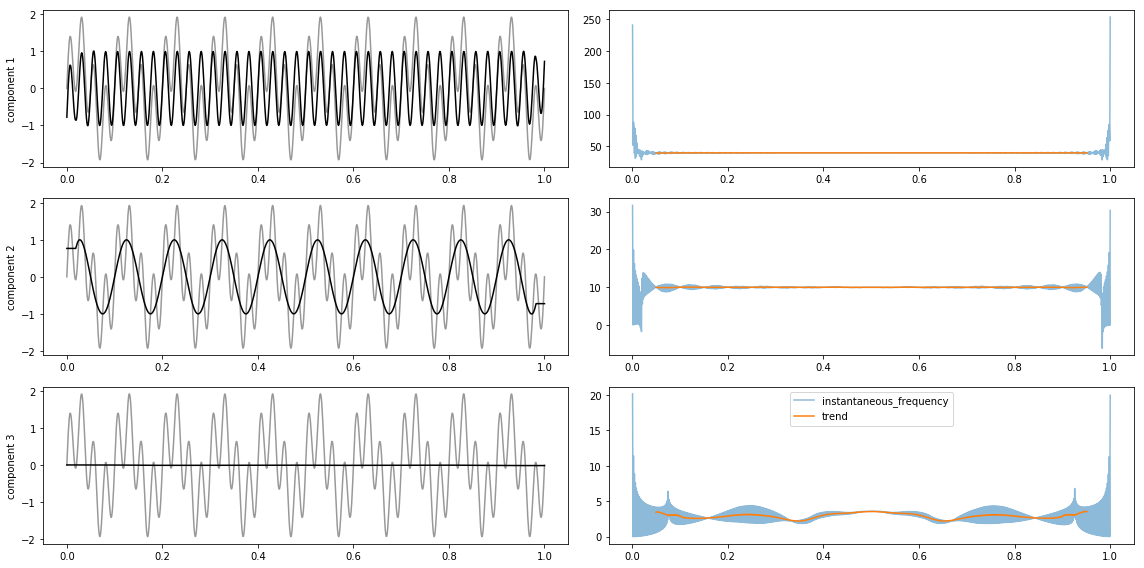

In [26]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 40
F=np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)
plot_emd(F, t, 'smooth', 2, 50, 51)

## Временной ряд из 2 гармоник c шумом:

mean of trend 40.00
mean of trend 11.18
mean of trend 4.18


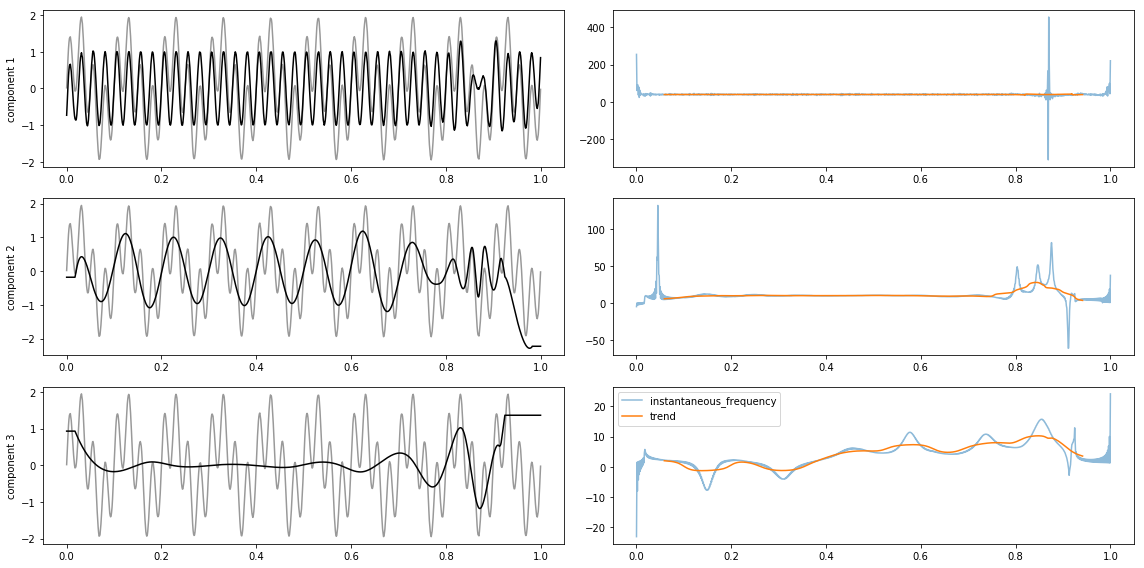

In [27]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 40
F=np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.01*rand.randn(len(t))
plot_emd(F, t, 'smooth', 2, 60, 101)

## Временной ряд из 4 гармоник без шума:

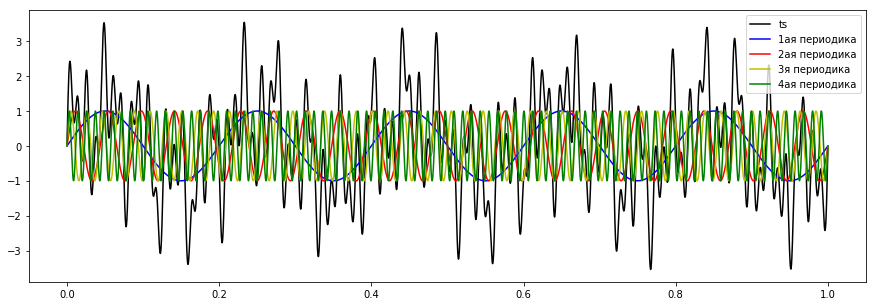

mean of trend 86.86
mean of trend 48.03
mean of trend 23.30
mean of trend 5.91
mean of trend 2.91


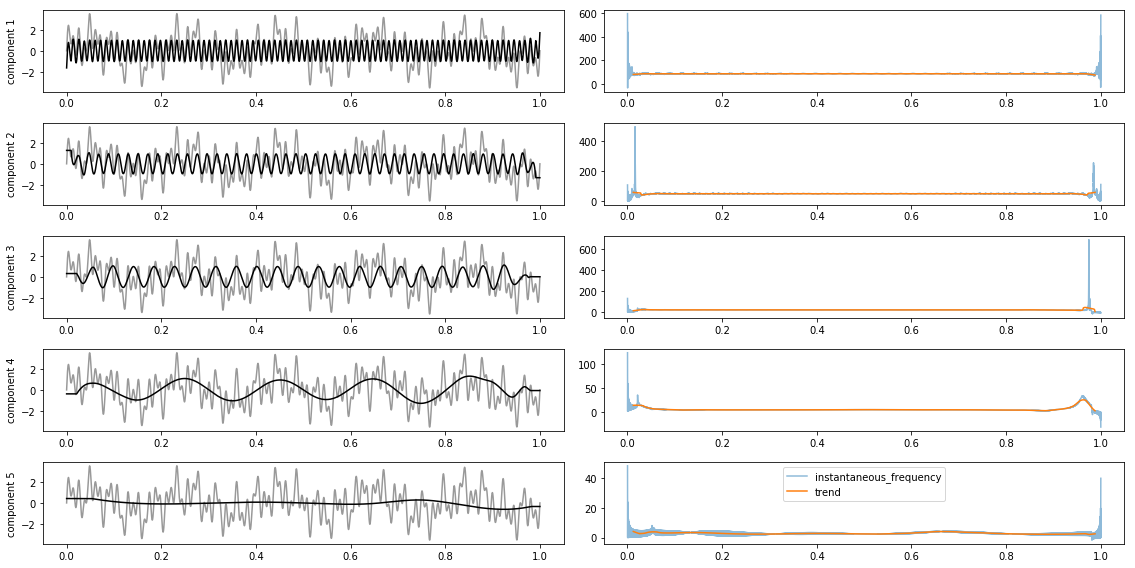

In [28]:
t = np.linspace(0, 1, 4096)
f1 = 5 #3
f2 = 23 #23
f3 = 48 #48
f4 = 87 #90
F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) \
    + np.sin(2*np.pi*f3*t) + np.sin(2*np.pi*f4*t)


plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k', label = 'ts')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b', label = '1ая периодика')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r', label = '2ая периодика')
plt.plot(t, np.sin(2*np.pi*f3*t), 'y', label = '3я периодика')
plt.plot(t, np.sin(2*np.pi*f4*t), 'g', label = '4ая периодика')
plt.legend()
plt.show()
plot_emd(F, t, 'smooth', 4, 50, 101)

## Временной ряд из 4 гармоник с шумом:

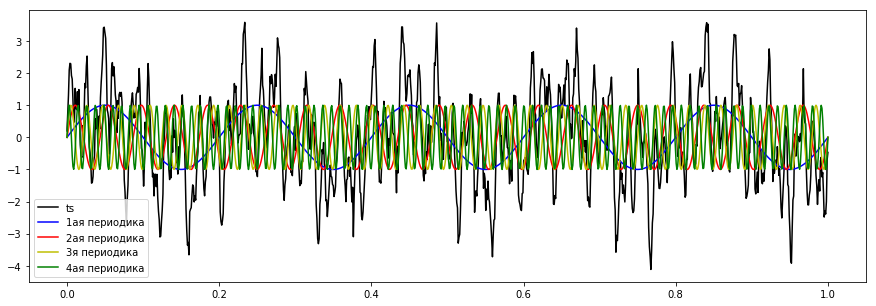

mean of trend 274.33
mean of trend 91.34
mean of trend 52.30
mean of trend 22.81
mean of trend 5.01


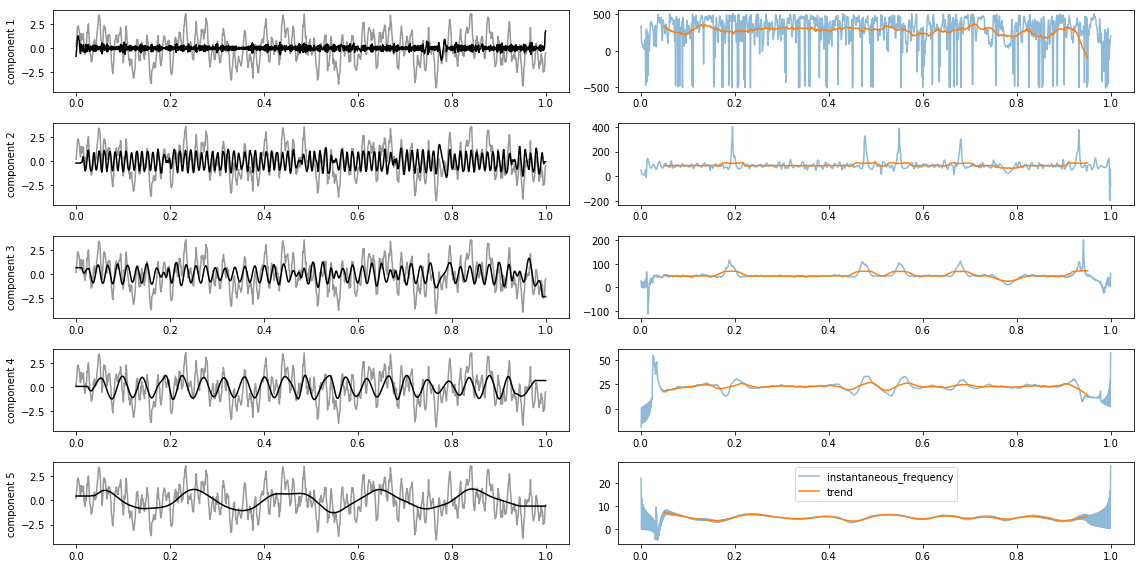

In [29]:
t = np.linspace(0, 1, 1024)
f1 = 5 #3
f2 = 23 #23
f3 = 48 #48
f4 = 87 #90
F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) \
    + np.sin(2*np.pi*f3*t) + np.sin(2*np.pi*f4*t) + 0.3*rand.randn(len(t))


plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k', label = 'ts')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b', label = '1ая периодика')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r', label = '2ая периодика')
plt.plot(t, np.sin(2*np.pi*f3*t), 'y', label = '3я периодика')
plt.plot(t, np.sin(2*np.pi*f4*t), 'g', label = '4ая периодика')
plt.legend()
plt.show()
plot_emd(F, t, 'smooth', 4, 50, 51)

Аналогично, попробуйте провести декомпозицию следующих
временных рядов: с изломом частоты (см. пункт 16), случайный ряд
белого шума с нормальным распределением, экспоненциальный
зашумленный тренд:
## Ряд с частотным изломом:

mean of trend 649.92
mean of trend 255.32


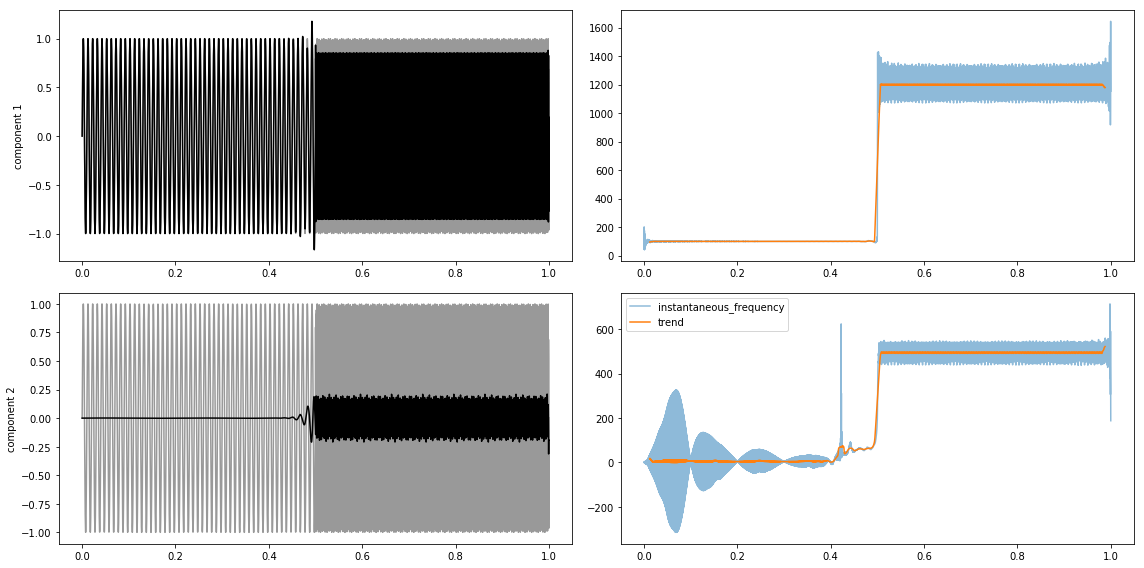

In [30]:
t = np.linspace(0, 1, 4096)
F = np.zeros(4096)

for i in range(0, len(t)//2):
    F[i] = np.sin(2*np.pi*100*t[i])
for i in range(len(t)//2, len(t)):
    F[i] = np.sin(2*np.pi*1200*t[i])

plot_emd(F, t, 'smooth', 1, 50, 51)

## Cлучайный ряд белого шума с нормальным распределением

mean of trend 1092.94
mean of trend 678.90
mean of trend 322.24
mean of trend 160.04
mean of trend 83.73
mean of trend 23.38


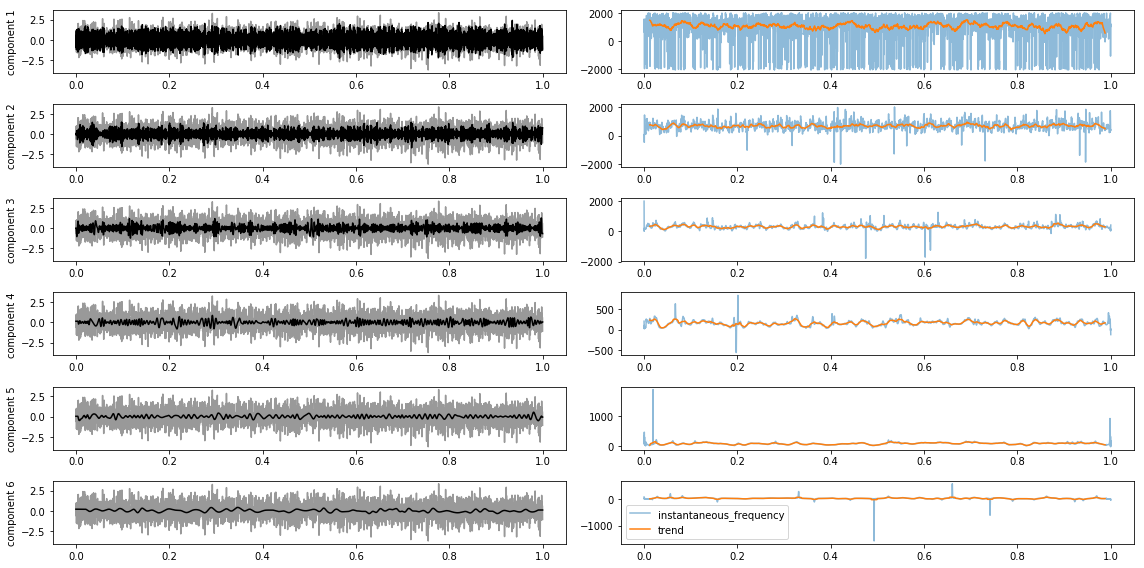

In [31]:
t = np.linspace(0, 1, 4096)
mean = 0
std = 1
F = np.random.normal(mean, std, size=4096)
plot_emd(F, t, 'smooth', 5, 50, 51)

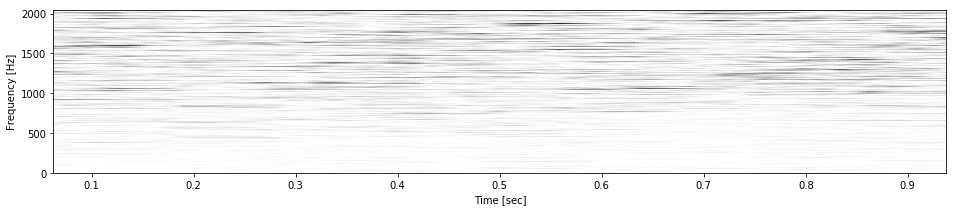

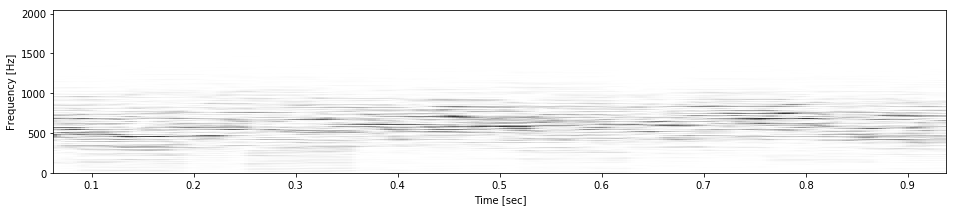

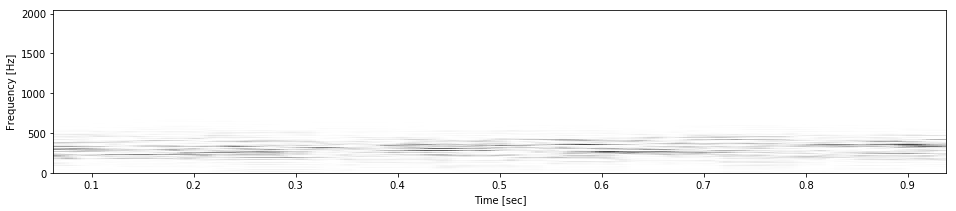

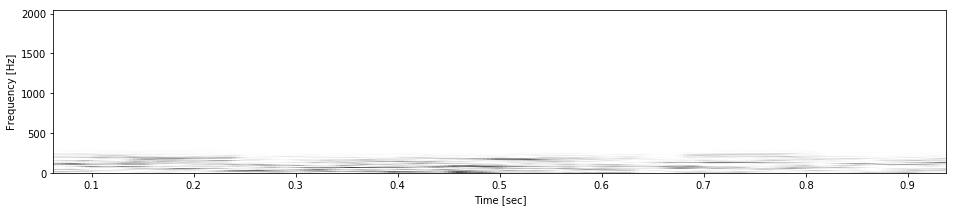

In [32]:
t = np.linspace(0, 1, 4096)
mean = 0
std = 1
F = np.random.normal(mean, std, size=4096)

fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
components = emd(F, n_components = 3)
for i in range(len(components)):
    f, t, Sxx = signal.spectrogram(components[i], fs, nperseg = 512, noverlap = 496, nfft=4096)

    plt.figure(figsize = (16, 3))
    plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

mean of trend 270.18
mean of trend 169.42
mean of trend 86.76
mean of trend 43.80
mean of trend 21.06
mean of trend 0.48


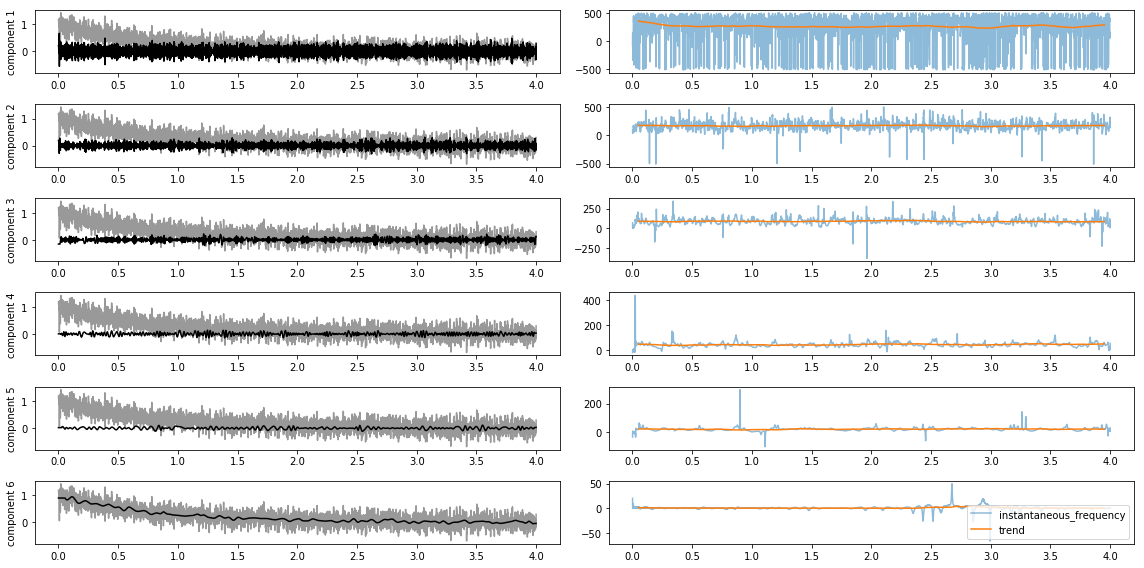

In [33]:
t = np.linspace(0, 4, 4096)
F = np.exp(-0.4*np.pi*t) + 0.2*rand.randn(len(t))
plot_emd(F, t, 'smooth', 5, 50, 515)
#plot_emd(F, t, 'exponential', 10, 50, 515)
# RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.